# 实验三

所有模板文件完整，无需重新创建
成功加载 340 个有效模板（含7、4增强模板）
训练样本数：340
训练精度：1.00
识别结果: 2073217611


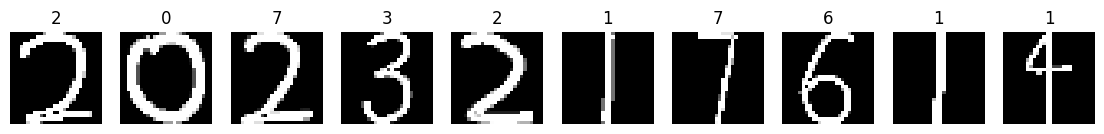

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


class Digit_Recognizer:
    def __init__(self, template_dir="templates_optimized"):
        self.template_dir = template_dir
        self.template_size = 28  
        self.num_variants = 30
        self.boost_digits = {7: 20, 4: 20}
        self._ensure_templates_complete()

        self.templates = self.load_templates()
        self.classifier = None
        self.scaler = StandardScaler()
        self.train_classifier()

    def _ensure_templates_complete(self):
        if not os.path.exists(self.template_dir):
            os.makedirs(self.template_dir, exist_ok=True)
        missing_count = 0
        
        for digit in range(10):
            for variant in range(self.num_variants):
                template_path = os.path.join(self.template_dir, f"digit_{digit}_var{variant}.png")
                if not os.path.exists(template_path):
                    missing_count += 1
        
        for digit, extra in self.boost_digits.items():
            for variant in range(self.num_variants, self.num_variants + extra):
                template_path = os.path.join(self.template_dir, f"digit_{digit}_var{variant}.png")
                if not os.path.exists(template_path):
                    missing_count += 1
        
        if missing_count > 0:
            print(f"检测到 {missing_count} 个模板")
            self.create_robust_templates()
        else:
            print("0-9所有模板文件完整")

    def create_robust_templates(self):
        # 基础模板
        for digit in range(10):
            for variant in range(self.num_variants):
                img = self.create_varied_digit(digit, variant)
                if img.shape != (self.template_size, self.template_size):
                    img = cv2.resize(img, (self.template_size, self.template_size))
                template_path = os.path.join(self.template_dir, f"digit_{digit}_var{variant}.png")
                cv2.imwrite(template_path, img)
        # 增强模板
        for digit, extra in self.boost_digits.items():
            for variant in range(self.num_variants, self.num_variants + extra):
                img = self.create_specific_digit(digit, variant)
                if img.shape != (self.template_size, self.template_size):
                    img = cv2.resize(img, (self.template_size, self.template_size))
                template_path = os.path.join(self.template_dir, f"digit_{digit}_var{variant}.png")
                cv2.imwrite(template_path, img)

    def create_varied_digit(self, digit, variant):
        img = np.zeros((self.template_size, self.template_size), dtype=np.uint8)
        fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_COMPLEX,
                 cv2.FONT_HERSHEY_DUPLEX, cv2.FONT_HERSHEY_PLAIN,
                 cv2.FONT_HERSHEY_TRIPLEX, cv2.FONT_HERSHEY_SCRIPT_SIMPLEX]
        font = fonts[variant % len(fonts)]
        scale = 0.6 + 0.2 * (variant % 4)
        thick = 1 + variant % 4
        txt = str(digit)
        (w, h), _ = cv2.getTextSize(txt, font, scale, thick)
        x = max(1, (self.template_size - w) // 2 + np.random.randint(-2, 3))
        y = max(h, (self.template_size + h) // 2 + np.random.randint(-2, 3))
        cv2.putText(img, txt, (x, y), font, scale, 255, thick)
        # 仿射变换
        if variant % 5 == 0:
            pts1 = np.float32([[5,5],[23,5],[5,23]])
            pts2 = np.float32([[5+np.random.randint(-1,2),5+np.random.randint(-1,2)],
                               [23+np.random.randint(-1,2),5+np.random.randint(-1,2)],
                               [5+np.random.randint(-1,2),23+np.random.randint(-1,2)]])
            M = cv2.getAffineTransform(pts1, pts2)
            img = cv2.warpAffine(img, M, (self.template_size, self.template_size))
        # 噪声
        if variant % 4 == 0:
            noise = np.random.randint(0, 2, img.shape, dtype=np.uint8) * 255
            if img.shape == noise.shape:
                img = cv2.bitwise_xor(img, noise)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return img

    def create_specific_digit(self, digit, variant):
        img = np.zeros((self.template_size, self.template_size), dtype=np.uint8)
        if digit == 7:
            cv2.line(img, (10, 5), (10, 20), 255, 2)  # 竖线
            cv2.line(img, (10, 5), (20, 5), 255, 2)   # 短横
        elif digit == 4:
            cv2.line(img, (10, 5), (10, 15), 255, 2)  # 竖线
            cv2.line(img, (10, 10), (20, 10), 255, 2) # 折角横线
            cv2.line(img, (20, 10), (20, 20), 255, 2) # 右侧竖线
        # 随机偏移
        x_offset = np.random.randint(-2, 3)
        y_offset = np.random.randint(-2, 3)
        M = np.float32([[1,0,x_offset],[0,1,y_offset]])
        img = cv2.warpAffine(img, M, (self.template_size, self.template_size))
        # 增加轻微噪声
        noise = np.random.randint(0, 2, img.shape, dtype=np.uint8) * 255
        img = cv2.bitwise_xor(img, noise)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return img

    def load_templates(self):
        templates = {i: [] for i in range(10)}
        # 加载基础模板
        for d in range(10):
            for v in range(self.num_variants):
                p = os.path.join(self.template_dir, f"digit_{d}_var{v}.png")
                if os.path.exists(p):
                    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                    if img is not None and img.shape == (self.template_size, self.template_size):
                        templates[d].append(img)
        # 加载增强模板
        for d, extra in self.boost_digits.items():
            for v in range(self.num_variants, self.num_variants + extra):
                p = os.path.join(self.template_dir, f"digit_{d}_var{v}.png")
                if os.path.exists(p):
                    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                    if img is not None and img.shape == (self.template_size, self.template_size):
                        templates[d].append(img)
        total = sum([len(templates[d]) for d in range(10)])
        print(f"成功加载 {total} 个有效模板（含7、4增强模板）")
        return templates

    def robust_preprocess(self, image_path):
        color = cv2.imread(image_path)
        gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
        if gray.shape[0] > 300:
            scale = 300 / gray.shape[0]
            gray = cv2.resize(gray, (int(gray.shape[1] * scale), 300))
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        binary = cv2.adaptiveThreshold(gray, 255, 
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY_INV, 7, 3)
        # 形态学膨胀，连接断裂笔画
        kernel = np.ones((2, 2), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)
        return binary, color, gray

    def extract_features(self, img):
        img = cv2.resize(img, (28, 28))
        pix = img.flatten() / 255.0
        
        # 几何特征
        m = cv2.moments(img)
        cx = m['m10'] / (m['m00'] + 1e-6)
        cy = m['m01'] / (m['m00'] + 1e-6)
        
        # 投影特征
        hproj = np.sum(img, axis=1) / 255
        vproj = np.sum(img, axis=0) / 255
        
        # 轮廓特征
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_feat = [len(contours)]  
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            contour_feat.extend([area, perimeter])
        else:
            contour_feat.extend([0, 0])
       
        # HOG特征
        hog = cv2.HOGDescriptor((28,28), (14,14), (7,7), (7,7), 9)
        hog_feat = hog.compute(img).flatten()
       
        # 拼接所有特征
        return np.concatenate([pix, [cx, cy], hproj, vproj, contour_feat, hog_feat])
      
      
      # 数字分割
    def smart_segmentation(self, binary):
        h, w = binary.shape
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        digits = []
        boxes = []
        min_area = 10
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] < min_area:
                continue
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w_digit = stats[i, cv2.CC_STAT_WIDTH]
            h_digit = stats[i, cv2.CC_STAT_HEIGHT]
            digit = binary[y:y+h_digit, x:x+w_digit]
            digit = self.prepare_digit(digit)
            digits.append(digit)
            boxes.append((x, y, w_digit, h_digit))
        if boxes:
            digits = [d for _, d in sorted(zip([b[0] for b in boxes], digits))]
        return digits, boxes
        # KNN分类器模块
    def train_classifier(self):
        X, y = [], []
        for d in range(10):
            for img in self.templates[d]:
                X.append(self.extract_features(img))
                y.append(d)
        X = np.array(X)
        y = np.array(y)
        print(f"训练样本数：{len(y)}")
        self.scaler.fit(X)
        Xs = self.scaler.transform(X)
        self.classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')
        self.classifier.fit(Xs, y)
        # 验证精度
        X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
        y_pred = self.classifier.predict(X_test)
        print(f"训练精度：{accuracy_score(y_test, y_pred):.2f}")
        
      

    def prepare_digit(self, digit):
        h, w = digit.shape
        max_dim = max(h, w)
        pad_h = (max_dim - h) // 2
        pad_w = (max_dim - w) // 2
        digit = cv2.copyMakeBorder(digit, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=0)
        digit = cv2.resize(digit, (28, 28))
        return digit

    def recognize_digit(self, img):
        feat = self.extract_features(img)
        feat = self.scaler.transform([feat])
        pred = self.classifier.predict(feat)[0]
        return pred

    def recognize_and_display(self, image_path, visualize=True):
        binary, color, gray = self.robust_preprocess(image_path)
        digits, boxes = self.smart_segmentation(binary)
        if not digits:
            print("未检测到数字区域")
            return "", color
        result = ""
        for d in digits:
            result += str(self.recognize_digit(d))
        print("识别结果:", result)
        if visualize:
            plt.figure(figsize=(14, 4))
            for i, d in enumerate(digits):
                plt.subplot(1, len(digits), i + 1)
                plt.imshow(d, cmap='gray')
                plt.title(result[i])
                plt.axis('off')
            plt.show()
        return result, color


def main():
    image_path = "XueHao.jpg" 
    if not os.path.exists(image_path):
        print(f"图片 {image_path} 不存在，请检查路径")
        return
    try:
        recog = RobustDigitRecognizer()
        recog.recognize_and_display(image_path)
    except Exception as e:
        print(f"程序异常：{e}")


if __name__ == "__main__":
    main() 